In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data
df = pd.read_csv(r"D:\Coding\Energy-Management_Project\data\data_15min.csv")

# show data
df.head(10)

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,Unnamed: 70
0,2014-12-11T17:45:00Z,2014-12-11T18:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-11T18:00:00Z,2014-12-11T19:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-11T18:15:00Z,2014-12-11T19:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-11T18:30:00Z,2014-12-11T19:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-11T18:45:00Z,2014-12-11T19:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-12-11T19:00:00Z,2014-12-11T20:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-12-11T19:15:00Z,2014-12-11T20:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-12-11T19:30:00Z,2014-12-11T20:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014-12-11T19:45:00Z,2014-12-11T20:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-12-11T20:00:00Z,2014-12-11T21:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# convert utc timestamp to datetime format

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])  # Convert to datetime
df.set_index('utc_timestamp', inplace=True)  # Set as index

In [ ]:
df.index.dtype

In [4]:
# checking missing values

df.isna().sum()

cet_cest_timestamp                         0
DE_KN_industrial1_grid_import          88080
DE_KN_industrial1_pv_1                 84659
DE_KN_industrial1_pv_2                 84659
DE_KN_industrial2_grid_import         108697
                                       ...  
DE_KN_residential6_grid_export         87055
DE_KN_residential6_grid_import         67677
DE_KN_residential6_pv                  67677
DE_KN_residential6_washing_machine     94674
Unnamed: 70                            32219
Length: 70, dtype: int64

In [5]:
# interpolation or forward fill

df.interpolate(method='time', inplace=True)  # Time-based interpolation
df.fillna(method='ffill', inplace=True)  # Forward fill


C:\Users\rrous\AppData\Local\Temp\ipykernel_41480\2124247814.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='time', inplace=True)  # Time-based interpolation
C:\Users\rrous\AppData\Local\Temp\ipykernel_41480\2124247814.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill


In [6]:
# checking missing values

df.isna().sum()

cet_cest_timestamp                        0
DE_KN_industrial1_grid_import         33744
DE_KN_industrial1_pv_1                30322
DE_KN_industrial1_pv_2                30322
DE_KN_industrial2_grid_import         41985
                                      ...  
DE_KN_residential6_grid_export        49807
DE_KN_residential6_grid_import        30429
DE_KN_residential6_pv                 30429
DE_KN_residential6_washing_machine    30425
Unnamed: 70                             301
Length: 70, dtype: int64

## Column Operations

In [7]:
# replace "DE_KN_" from all column names

df.columns = df.columns.str.replace("DE_KN_", "", regex=True)


In [8]:
df.columns

Index(['cet_cest_timestamp', 'industrial1_grid_import', 'industrial1_pv_1',
       'industrial1_pv_2', 'industrial2_grid_import', 'industrial2_pv',
       'industrial2_storage_charge', 'industrial2_storage_decharge',
       'industrial3_area_offices', 'industrial3_area_room_1',
       'industrial3_area_room_2', 'industrial3_area_room_3',
       'industrial3_area_room_4', 'industrial3_compressor',
       'industrial3_cooling_aggregate', 'industrial3_cooling_pumps',
       'industrial3_dishwasher', 'industrial3_ev', 'industrial3_grid_import',
       'industrial3_machine_1', 'industrial3_machine_2',
       'industrial3_machine_3', 'industrial3_machine_4',
       'industrial3_machine_5', 'industrial3_pv_facade', 'industrial3_pv_roof',
       'industrial3_refrigerator', 'industrial3_ventilation',
       'public1_grid_import', 'public2_grid_import', 'residential1_dishwasher',
       'residential1_freezer', 'residential1_grid_import',
       'residential1_heat_pump', 'residential1_pv',
      

In [9]:
# Renaming categories, e.g: industrial4 --> i4

import re

# Function to rename categories
def rename_category(col_name):
    col_name = re.sub(r"industrial(\d+)", r"i\1", col_name)  # industrialX → iX
    col_name = re.sub(r"public(\d+)", r"p\1", col_name)  # publicX → pX
    col_name = re.sub(r"residential(\d+)", r"r\1", col_name)  # residentialX → rX
    return col_name

# Apply renaming function to all column names
df.columns = [rename_category(col) for col in df.columns]


In [10]:
df.columns

Index(['cet_cest_timestamp', 'i1_grid_import', 'i1_pv_1', 'i1_pv_2',
       'i2_grid_import', 'i2_pv', 'i2_storage_charge', 'i2_storage_decharge',
       'i3_area_offices', 'i3_area_room_1', 'i3_area_room_2', 'i3_area_room_3',
       'i3_area_room_4', 'i3_compressor', 'i3_cooling_aggregate',
       'i3_cooling_pumps', 'i3_dishwasher', 'i3_ev', 'i3_grid_import',
       'i3_machine_1', 'i3_machine_2', 'i3_machine_3', 'i3_machine_4',
       'i3_machine_5', 'i3_pv_facade', 'i3_pv_roof', 'i3_refrigerator',
       'i3_ventilation', 'p1_grid_import', 'p2_grid_import', 'r1_dishwasher',
       'r1_freezer', 'r1_grid_import', 'r1_heat_pump', 'r1_pv',
       'r1_washing_machine', 'r2_circulation_pump', 'r2_dishwasher',
       'r2_freezer', 'r2_grid_import', 'r2_washing_machine',
       'r3_circulation_pump', 'r3_dishwasher', 'r3_freezer', 'r3_grid_export',
       'r3_grid_import', 'r3_pv', 'r3_refrigerator', 'r3_washing_machine',
       'r4_dishwasher', 'r4_ev', 'r4_freezer', 'r4_grid_export',
  

In [11]:
# drop "unnamed" column

df.drop(columns=["Unnamed: 70"], inplace=True)


In [12]:
df.columns

Index(['cet_cest_timestamp', 'i1_grid_import', 'i1_pv_1', 'i1_pv_2',
       'i2_grid_import', 'i2_pv', 'i2_storage_charge', 'i2_storage_decharge',
       'i3_area_offices', 'i3_area_room_1', 'i3_area_room_2', 'i3_area_room_3',
       'i3_area_room_4', 'i3_compressor', 'i3_cooling_aggregate',
       'i3_cooling_pumps', 'i3_dishwasher', 'i3_ev', 'i3_grid_import',
       'i3_machine_1', 'i3_machine_2', 'i3_machine_3', 'i3_machine_4',
       'i3_machine_5', 'i3_pv_facade', 'i3_pv_roof', 'i3_refrigerator',
       'i3_ventilation', 'p1_grid_import', 'p2_grid_import', 'r1_dishwasher',
       'r1_freezer', 'r1_grid_import', 'r1_heat_pump', 'r1_pv',
       'r1_washing_machine', 'r2_circulation_pump', 'r2_dishwasher',
       'r2_freezer', 'r2_grid_import', 'r2_washing_machine',
       'r3_circulation_pump', 'r3_dishwasher', 'r3_freezer', 'r3_grid_export',
       'r3_grid_import', 'r3_pv', 'r3_refrigerator', 'r3_washing_machine',
       'r4_dishwasher', 'r4_ev', 'r4_freezer', 'r4_grid_export',
  

In [13]:
# fill NaN with 0

df.fillna(0, inplace=True)


## Data Description

In [14]:
# total values > 0 in each column

count = (df['p2_grid_import'] > 0).sum()
print(f"Number of rows where 'p2_grid_import' > 0: {count}")

count = (df['i2_grid_import'] > 0).sum()
print(f"Number of rows where 'i2_grid_import' > 0: {count}")


count = (df['i3_grid_import'] > 0).sum()
print(f"Number of rows where 'i3_grid_import' > 0: {count}")

count = (df['r1_grid_import'] > 0).sum()
print(f"Number of rows where 'r1_grid_import' > 0: {count}")

count = (df['r4_grid_import'] > 0).sum()
print(f"Number of rows where 'r4_grid_import' > 0: {count}")



Number of rows where 'p2_grid_import' > 0: 84610
Number of rows where 'i2_grid_import' > 0: 111825
Number of rows where 'i3_grid_import' > 0: 112852
Number of rows where 'r1_grid_import' > 0: 138363
Number of rows where 'r4_grid_import' > 0: 124727


In [15]:
# data description

print(df.describe())

       i1_grid_import        i1_pv_1        i1_pv_2  i2_grid_import  \
count   153810.000000  153810.000000  153810.000000   153810.000000   
mean    275239.390097    5918.760899    4553.427506     9588.183520   
std     216788.433987    4665.771826    3550.023449     7448.848147   
min          0.000000       0.000000       0.000000        0.000000   
25%      24754.437500     405.940000     273.845000        0.000000   
50%     289379.367000    5571.942000    4391.593000    13734.177000   
75%     511112.711000   11001.342000    8377.523000    16699.016000   
max     511112.711000   11001.342000    8377.523000    16699.016000   

               i2_pv  i2_storage_charge  i2_storage_decharge  i3_area_offices  \
count  153810.000000      153810.000000        153810.000000    153810.000000   
mean    14205.244460         893.461889           541.774304     10141.113316   
std      9615.878858         706.270115           427.143250      6621.013695   
min         0.000000           0.000

<Axes: title={'center': 'Time Series Trends'}, xlabel='utc_timestamp'>

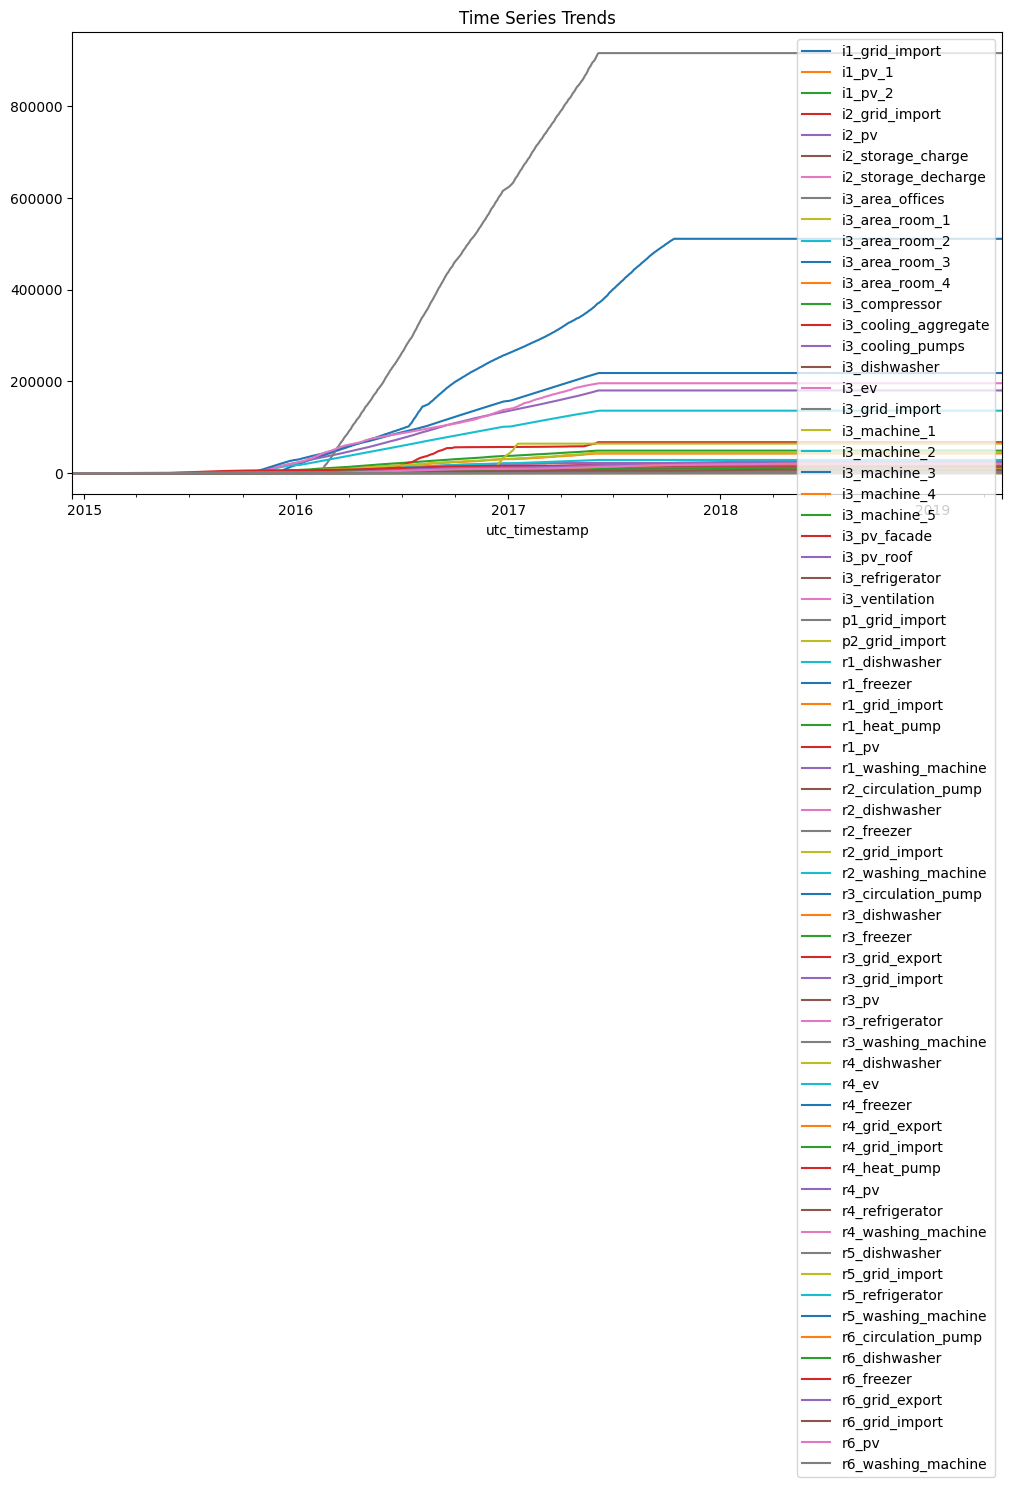

In [16]:
#time series trends

df.plot(figsize=(12, 6), title="Time Series Trends")


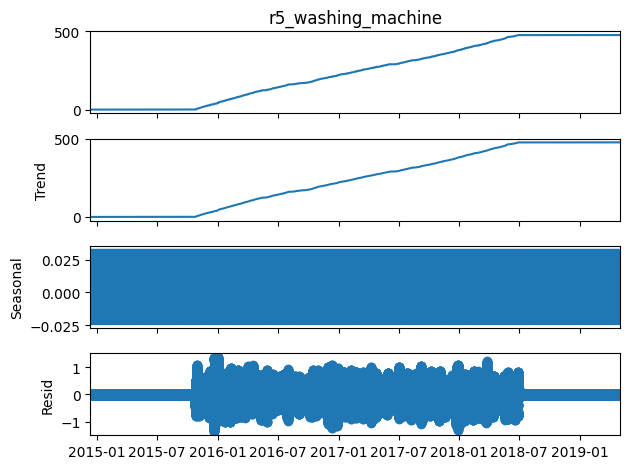

In [17]:
# Seasonal Decomposition Check
#Trend → Long-term increase/decrease in consumption.
#Seasonality → Repeating patterns (daily, weekly, yearly).
#Residuals → Random fluctuations.

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(df['r5_washing_machine'], model='additive', period=365)
result.plot()
plt.show()


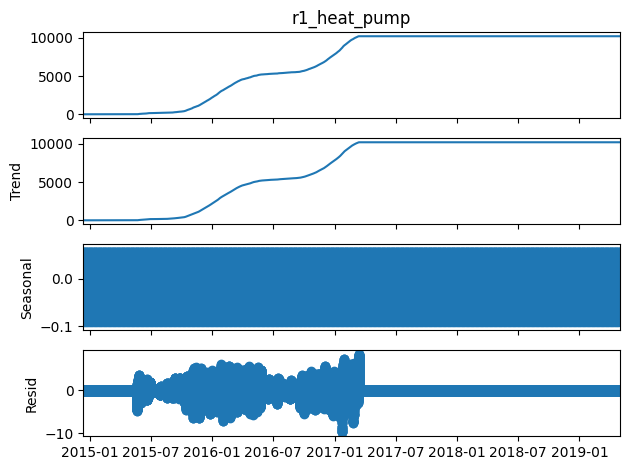

In [18]:
result = seasonal_decompose(df['r1_heat_pump'], model='additive', period=365)
result.plot()
plt.show()


## Model Building

### Prophet Algorithm

In [19]:
from prophet import Prophet

d:\Coding\Energy_Management\em\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [20]:
# Prepare DataFrame for Prophet: reset index to get datetime as column 'ds'

df_prophet = df[['r6_washing_machine']].copy()  # take only target col
df_prophet['ds'] = df_prophet.index  # move index to column

In [21]:
# Remove timezone info from 'ds' column
df_prophet['ds'] = df_prophet['ds'].dt.tz_convert(None)

In [22]:
# Rename target column to 'y' as Prophet expects
df_prophet = df_prophet.rename(columns={'r6_washing_machine': 'y'})

In [23]:
# Filter training data: 1 month data from Jan 2016
train_1m = df_prophet[(df_prophet['ds'] >= '2016-01-01') & (df_prophet['ds'] < '2016-02-01')]


In [24]:
# check before training model

print(f"Training data shape: {train_1m.shape}")
print(train_1m.head())



Training data shape: (2976, 2)
                               y                  ds
utc_timestamp                                       
2016-01-01 00:00:00+00:00  8.777 2016-01-01 00:00:00
2016-01-01 00:15:00+00:00  8.777 2016-01-01 00:15:00
2016-01-01 00:30:00+00:00  8.777 2016-01-01 00:30:00
2016-01-01 00:45:00+00:00  8.777 2016-01-01 00:45:00
2016-01-01 01:00:00+00:00  8.777 2016-01-01 01:00:00


In [25]:
# Initialize Prophet model with daily and weekly seasonality (yearly off for short data)

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)


In [26]:
# Fit model
model.fit(train_1m)


13:28:01 - cmdstanpy - INFO - Chain [1] start processing
13:28:05 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Create future dataframe for next 2 days (15-min freq, 96 intervals per day)

future = model.make_future_dataframe(periods=96*2, freq='15min')

In [28]:
# Predict future usage
forecast = model.predict(future)


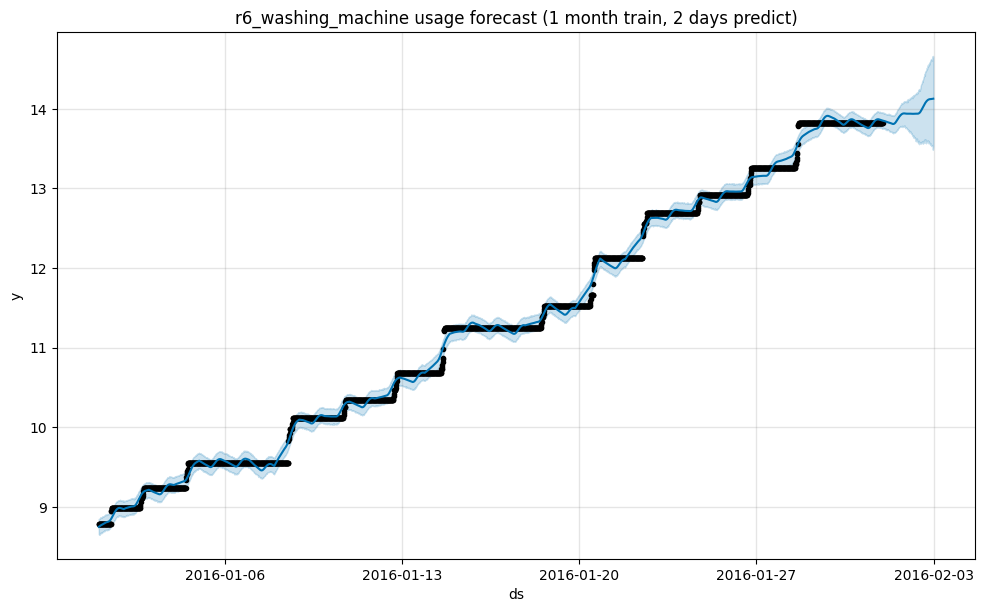

In [29]:
# Plot forecast
model.plot(forecast)
plt.title('r6_washing_machine usage forecast (1 month train, 2 days predict)')
plt.show()

In [ ]:
# Define test period start and end (2 days after training)
test_start = pd.Timestamp('2016-02-01')
test_end = pd.Timestamp('2016-02-02 23:45:00')  # end of 2nd Feb with 15-min freq

# Filter forecast for test period
forecast_test = forecast[(forecast['ds'] >= test_start) & (forecast['ds'] <= test_end)]


actual_test = df_prophet[(df_prophet['ds'] >= test_start) & (df_prophet['ds'] <= test_end)]


df_eval = pd.merge(actual_test, forecast_test[['ds', 'yhat']], on='ds', how='inner')

# Calculate metrics
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
# Calculate RMSE manually (for older sklearn versions without squared parameter)
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))

r2 = r2_score(df_eval['y'], df_eval['yhat'])

# Create summary DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R² Score'],
    'Value': [mae, rmse, r2]
})

print(metrics_df)


     Metric     Value
0       MAE  0.091027
1      RMSE  0.115129
2  R² Score  0.046696


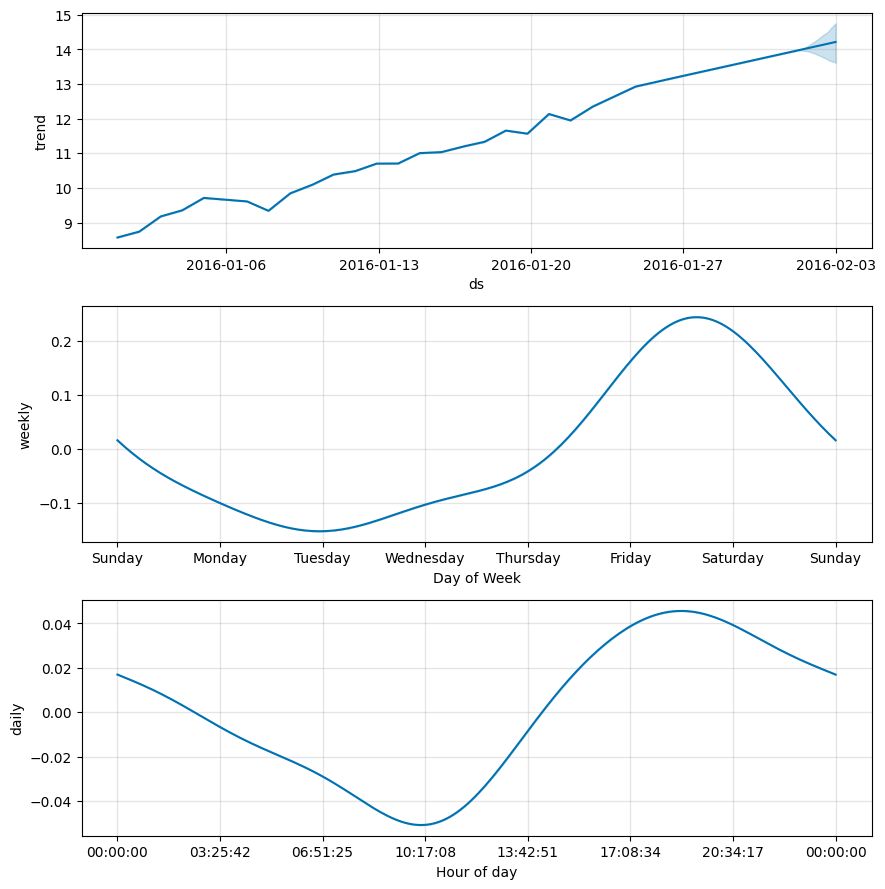

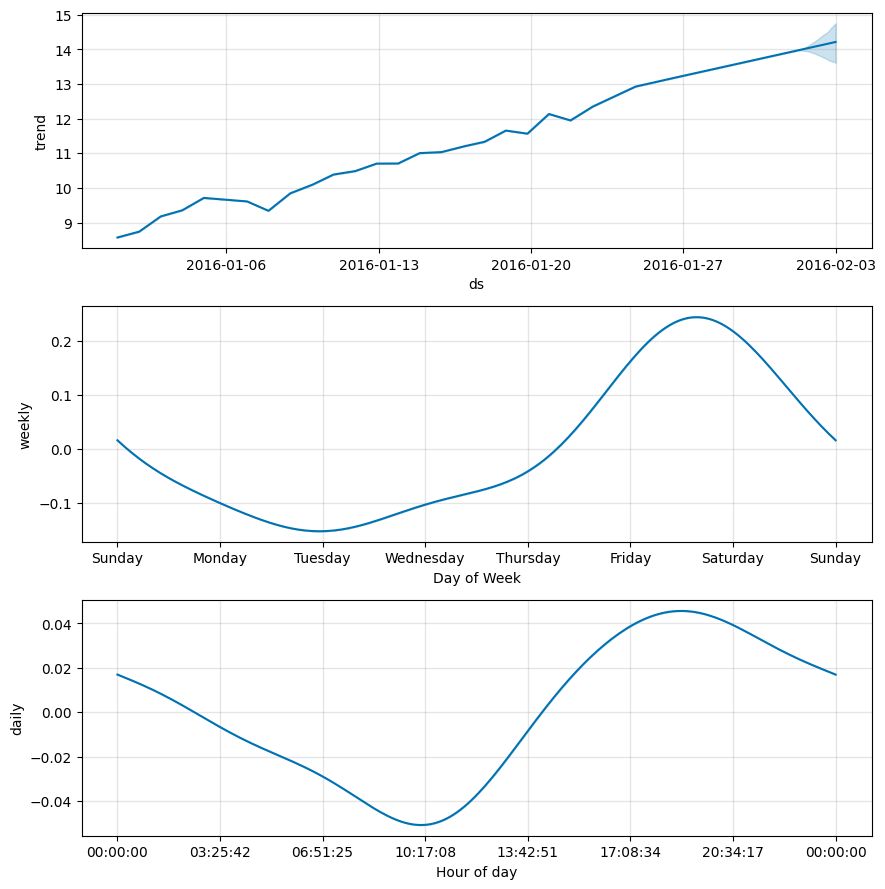

In [35]:
from prophet.plot import plot_plotly, plot_components_plotly


# Plot the forecast components (trend, weekly and daily seasonality)
model.plot_components(forecast)


## XGBoost with Lag Features

In [171]:
import numpy as np
import pandas as pd

In [172]:


df2 = pd.read_csv(r'D:\Coding\Energy-Management_Project\data\data_15min.csv')
df2.head(10)

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,Unnamed: 70
0,2014-12-11T17:45:00Z,2014-12-11T18:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-11T18:00:00Z,2014-12-11T19:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-11T18:15:00Z,2014-12-11T19:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-11T18:30:00Z,2014-12-11T19:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-11T18:45:00Z,2014-12-11T19:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-12-11T19:00:00Z,2014-12-11T20:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-12-11T19:15:00Z,2014-12-11T20:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-12-11T19:30:00Z,2014-12-11T20:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014-12-11T19:45:00Z,2014-12-11T20:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-12-11T20:00:00Z,2014-12-11T21:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
# Parse datetime and set index

df2['utc_timestamp'] = pd.to_datetime(df2['utc_timestamp'])
df2.set_index('utc_timestamp', inplace=True)

In [174]:
# Rename target column to 'r6_wm'

df2.rename(columns={"DE_KN_residential6_washing_machine": "r6_wm"}, inplace=True)

In [175]:
# Keep only timestamp and target

df2 = df2[["cet_cest_timestamp", "r6_wm"]]


In [176]:
# Sort by timestamp ascending

df2 = df2.sort_values("utc_timestamp").reset_index(drop=True)

In [177]:
# Handle missing values (forward fill, then backward fill)

df2["r6_wm"].fillna(method="ffill", inplace=True)
df2["r6_wm"].fillna(method="bfill", inplace=True)

C:\Users\rrous\AppData\Local\Temp\ipykernel_41480\2341466300.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["r6_wm"].fillna(method="ffill", inplace=True)
C:\Users\rrous\AppData\Local\Temp\ipykernel_41480\2341466300.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2["r6_wm"].fillna(method="ffill", inplace=True)
C:\Users\rrous\AppData\Local\Temp\ipykernel_41480\2341466300.py:4: FutureWarning: A value is trying to be set on a co

In [178]:
# Create lag features (1 lag = 15 min, 4 lags = 1 hour, 96 lags = 1 day, 672 lags = 1 week)

df2["lag_1"] = df2["r6_wm"].shift(1)
df2["lag_4"] = df2["r6_wm"].shift(4)
df2["lag_96"] = df2["r6_wm"].shift(96)
df2["lag_672"] = df2["r6_wm"].shift(672)

In [179]:
# Create rolling features on full df2 (shift to avoid leakage)

df2['rolling_mean_4h'] = df2['r6_wm'].rolling(window=16).mean().shift(1)  # 4 hours rolling mean, shifted
df2['rolling_std_4h'] = df2['r6_wm'].rolling(window=16).std().shift(1)
df2['rolling_mean_1d'] = df2['r6_wm'].rolling(window=96).mean().shift(1)  # 1 day rolling mean, shifted
df2['rolling_std_1d'] = df2['r6_wm'].rolling(window=96).std().shift(1)

In [180]:
# Drop rows with NaNs introduced by rolling calculations

df2 = df2.dropna(subset=['rolling_mean_4h', 'rolling_std_4h', 'rolling_mean_1d', 'rolling_std_1d'])

#removes the initial rows that don’t have enough past data to compute the rolling statistics
#makes the dataset ready for model training without missing values.

In [187]:
import pytz

tz = pytz.UTC  # or the timezone your data uses

train_start = pd.Timestamp("2016-01-01").tz_localize(tz)
train_end = pd.Timestamp("2016-01-31 23:59:59").tz_localize(tz)
test_start = pd.Timestamp("2016-02-01").tz_localize(tz)
test_end = pd.Timestamp("2016-02-10 23:59:59").tz_localize(tz)


In [188]:
# Filter train and test data

train_mask = (df2["cet_cest_timestamp"] >= train_start) & (df2["cet_cest_timestamp"] <= train_end)
test_mask = (df2["cet_cest_timestamp"] >= test_start) & (df2["cet_cest_timestamp"] <= test_end)


In [189]:
train_data = df2.loc[train_mask].copy()
test_data = df2.loc[test_mask].copy()

In [190]:
# Add time-based features

for df in [train_data, test_data]:
    df['month'] = df['cet_cest_timestamp'].dt.month
    df['day_of_year'] = df['cet_cest_timestamp'].dt.dayofyear
    df['weekday'] = df['cet_cest_timestamp'].dt.weekday

# forecasting model learns recurring patterns related to time of year and day of week

AttributeError: Can only use .dt accessor with datetimelike values

In [122]:
# Features and target columns (exclude datetime and target)

exclude_cols = ['cet_cest_timestamp', 'r6_wm']
feature_cols = [col for col in df2.columns if col not in ["cet_cest_timestamp", "r6_wm"]]

In [123]:
X_train = train_data[feature_cols]
y_train = train_data["r6_wm"]

X_test = test_data[feature_cols]
y_test = test_data["r6_wm"]

In [124]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Train XGBoost regression model

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [126]:
# Predict on test set

y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.6284


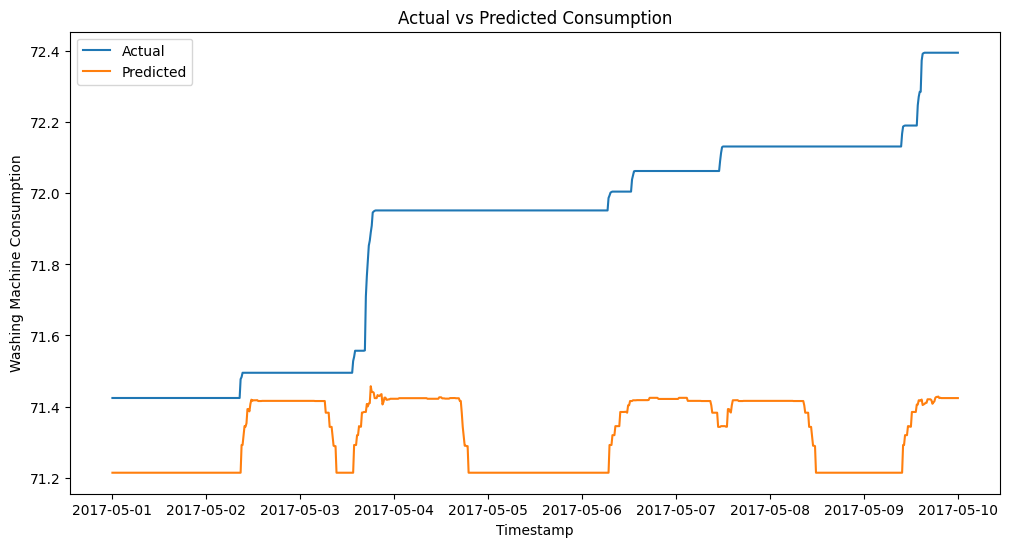

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_data["cet_cest_timestamp"], y_test, label="Actual")
plt.plot(test_data["cet_cest_timestamp"], y_pred, label="Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Washing Machine Consumption")
plt.title("Actual vs Predicted Consumption")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# model performed worse since R² < 0.


MAE: 0.5619
R² Score: -3.5921


In [137]:
print("Train mean:", y_train.mean(), "| Test mean:", y_test.mean())
print("Train std:", y_train.std(), "| Test std:", y_test.std())


Train mean: 38.0881596615193 | Test mean: 71.88117456647399
Train std: 16.630057983916767 | Test std: 0.29341475479918816


In [138]:
test_data[["r6_wm", "lag_96", "rolling_mean_1d"]].describe()


,r6_wm,lag_96,rolling_mean_1d
count,865.000000,865.000000,865.000000
mean,71.881175,71.789319,71.831233
std,0.293415,0.289834,0.282942
min,71.424000,71.424000,71.424000
25%,71.495000,71.424000,71.486552
50%,71.952000,71.952000,71.952000
75%,72.132000,72.063000,72.081771
max,72.396000,72.132000,72.248906


In [139]:
# Create DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
})

# Sort by importance descending
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print(feature_importance_df)

           feature  importance
0            lag_1    0.518332
1  rolling_mean_1d    0.192158
2           lag_96    0.182833
3          lag_672    0.065821
4  rolling_mean_4h    0.027806
5            lag_4    0.013042
6   rolling_std_1d    0.000005
7   rolling_std_4h    0.000004


In [113]:
print(X_test.describe())


       lag_1  lag_4  lag_96  lag_672  rolling_mean_4h  rolling_std_4h  \
count    0.0    0.0     0.0      0.0              0.0             0.0   
mean     NaN    NaN     NaN      NaN              NaN             NaN   
std      NaN    NaN     NaN      NaN              NaN             NaN   
min      NaN    NaN     NaN      NaN              NaN             NaN   
25%      NaN    NaN     NaN      NaN              NaN             NaN   
50%      NaN    NaN     NaN      NaN              NaN             NaN   
75%      NaN    NaN     NaN      NaN              NaN             NaN   
max      NaN    NaN     NaN      NaN              NaN             NaN   

       rolling_mean_1d  rolling_std_1d  
count              0.0             0.0  
mean               NaN             NaN  
std                NaN             NaN  
min                NaN             NaN  
25%                NaN             NaN  
50%                NaN             NaN  
75%                NaN             NaN  
max           

In [114]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())


lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64
lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64


In [99]:
print(len(train_data), len(test_data))


14497 865


In [115]:
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
print(results.tail())


Empty DataFrame
Columns: [actual, predicted]
Index: []


In [116]:
# Check for nulls in features
print("Train features missing values:\n", X_train.isnull().sum())
print("Test features missing values:\n", X_test.isnull().sum())

# Check data shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Check train and test date ranges
print("Train date range:", train_data['cet_cest_timestamp'].min(), "to", train_data['cet_cest_timestamp'].max())
print("Test date range:", test_data['cet_cest_timestamp'].min(), "to", test_data['cet_cest_timestamp'].max())

# Check target distributions
print("Train target stats:\n", y_train.describe())
print("Test target stats:\n", y_test.describe())


Train features missing values:
 lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64
Test features missing values:
 lag_1              0
lag_4              0
lag_96             0
lag_672            0
rolling_mean_4h    0
rolling_std_4h     0
rolling_mean_1d    0
rolling_std_1d     0
dtype: int64
Train shape: (116825, 8), Test shape: (0, 8)
Train date range: 2016-01-01 00:00:00 to 2019-05-01 22:00:00
Test date range: NaT to NaT
Train target stats:
 count    116825.000000
mean         62.305955
std          22.353329
min           8.777000
25%          42.273000
50%          78.641000
75%          78.641000
max          78.641000
Name: r6_wm, dtype: float64
Test target stats:
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: r6_wm, dtype: float64


## Analyzing Feature behaviour

In [129]:
# Narrow down the test range to zoom in on the jump period

analysis_start = pd.Timestamp("2017-05-01")
analysis_end = pd.Timestamp("2017-05-10")

analysis_data = test_data[
    (test_data['cet_cest_timestamp'] >= analysis_start) &
    (test_data['cet_cest_timestamp'] <= analysis_end)
].copy()

analysis_data['y_true'] = y_test.loc[analysis_data.index]
analysis_data['y_pred'] = y_pred  # ensure y_pred is aligned


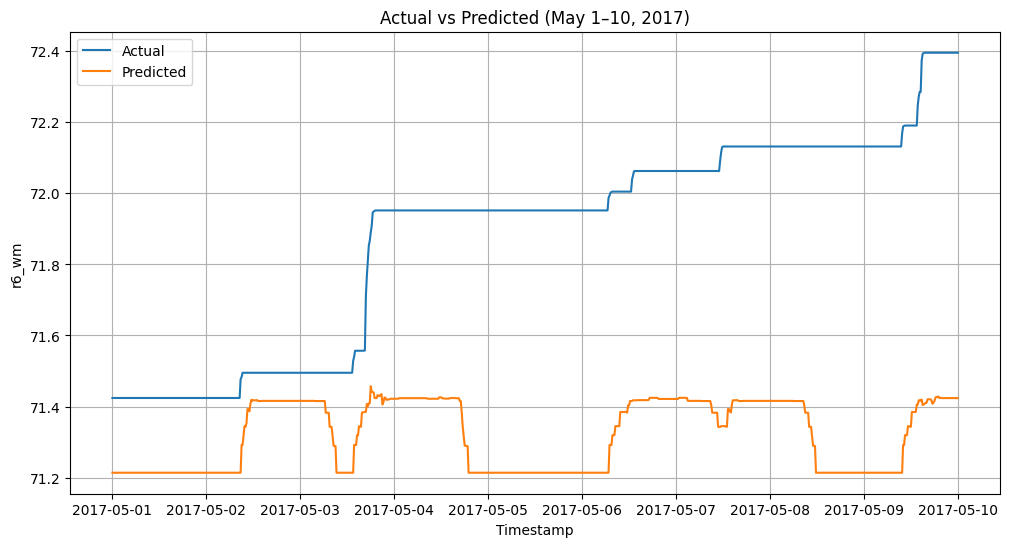

In [130]:


plt.figure(figsize=(12, 6))
plt.plot(analysis_data['cet_cest_timestamp'], analysis_data['y_true'], label='Actual')
plt.plot(analysis_data['cet_cest_timestamp'], analysis_data['y_pred'], label='Predicted')
plt.title('Actual vs Predicted (May 1–10, 2017)')
plt.xlabel('Timestamp')
plt.ylabel('r6_wm')
plt.legend()
plt.grid(True)
plt.show()


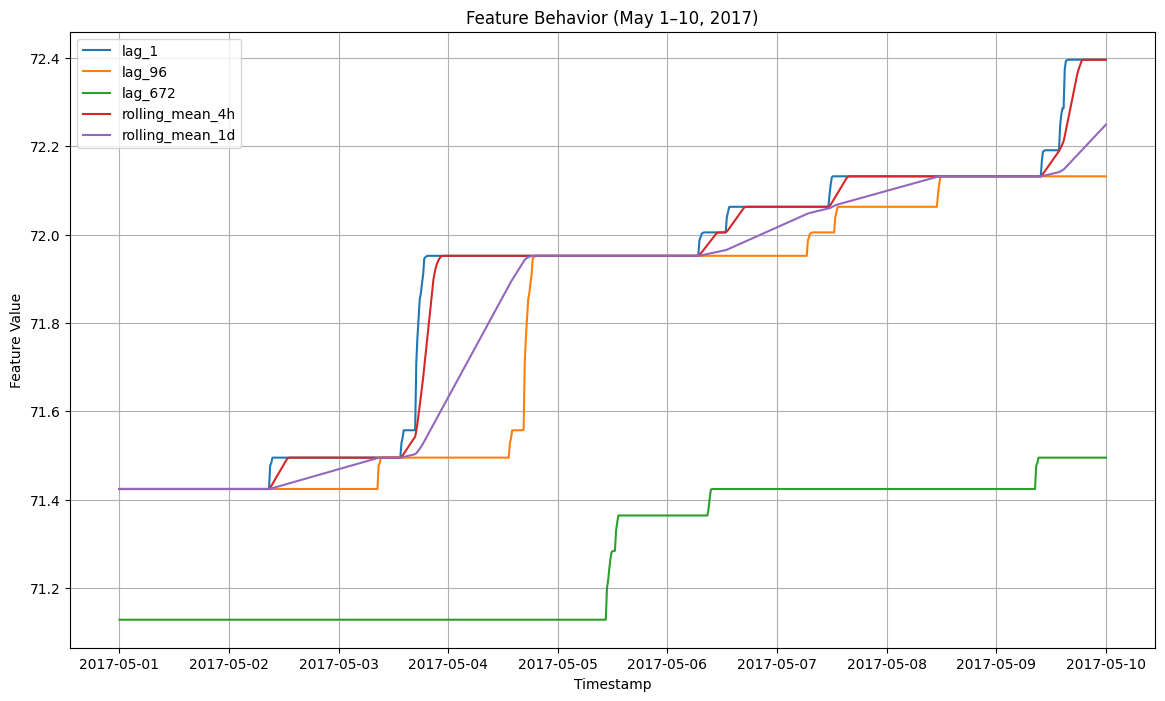

In [131]:
# plot feature behaviour over time

feature_subset = ['lag_1', 'lag_96', 'lag_672', 'rolling_mean_4h', 'rolling_mean_1d']

plt.figure(figsize=(14, 8))
for feature in feature_subset:
    plt.plot(analysis_data['cet_cest_timestamp'], analysis_data[feature], label=feature)

plt.title('Feature Behavior (May 1–10, 2017)')
plt.xlabel('Timestamp')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.show()


In [132]:
# correltion check

corr_matrix = analysis_data[feature_subset + ['y_pred']].corr()
print(corr_matrix['y_pred'].sort_values(ascending=False))


y_pred             1.000000
lag_1              0.285237
rolling_mean_4h    0.263891
lag_672            0.171578
rolling_mean_1d    0.126056
lag_96            -0.020177
Name: y_pred, dtype: float64


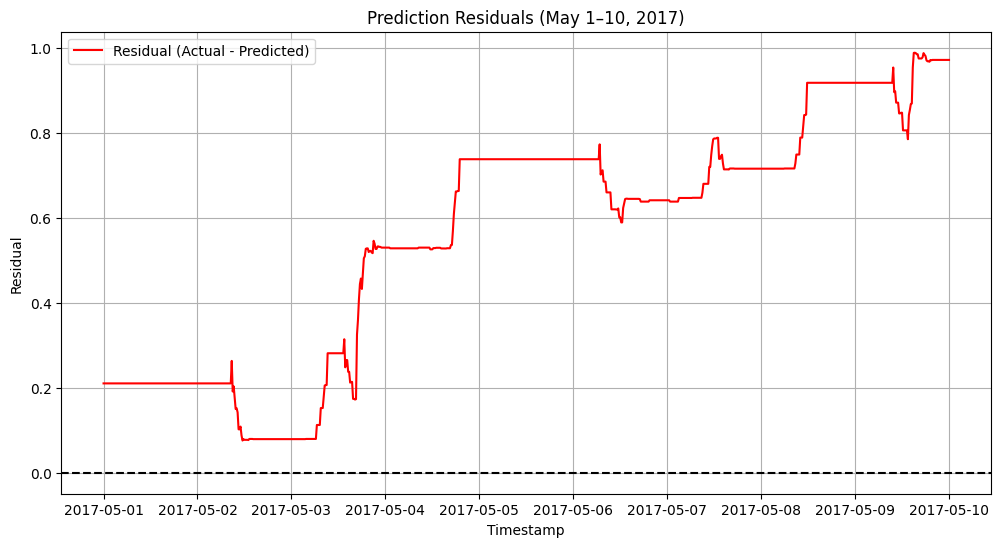

In [133]:
# viz residuals

analysis_data['residual'] = analysis_data['y_true'] - analysis_data['y_pred']

plt.figure(figsize=(12,6))
plt.plot(analysis_data['cet_cest_timestamp'], analysis_data['residual'], label='Residual (Actual - Predicted)', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Prediction Residuals (May 1–10, 2017)')
plt.xlabel('Timestamp')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()
